In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from pydub import AudioSegment
from pydub.silence import split_on_silence

In [2]:
def nextPowerOf2(n): 
    count = 0; 
  
    if (n and not(n & (n - 1))): 
        return n 
      
    while( n != 0): 
        n >>= 1
        count += 1
      
    return 1 << count; 

In [3]:
def fillWithZero(data):
    zeros = np.zeros(nextPowerOf2(len(data)) - len(data))
    return np.append(data, zeros)

In [4]:
def dft(fx):
    fx = np.asarray(fx, dtype=complex)
    M = fx.shape[0]
    fu = fx.copy()

    for i in range(M):
        u = i
        sum = 0
        for j in range(M):
            x = j
            tmp = fx[x]*np.exp(-2j*np.pi*x*u*np.divide(1, M, dtype=complex))
            sum += tmp
        fu[u] = sum

    return fu

In [5]:
def fft(fx):
    """ use recursive method to speed up"""
    fx = np.asarray(fx, dtype=complex)
    M = fx.shape[0]
    minDivideSize = 4

    if M % 2 != 0:
        raise ValueError("the input size must be 2^n")

    if M <= minDivideSize:
        return dft(fx)
    else:
        fx_even = fft(fx[::2])
        fx_odd = fft(fx[1::2])
        W_ux_2k = np.exp(-2j * np.pi * np.arange(M) / M)

        f_u = fx_even + fx_odd * W_ux_2k[:M//2]
        
        f_u_plus_k = fx_even + fx_odd * W_ux_2k[M//2:]
        
        fu = np.concatenate([f_u, f_u_plus_k])

    return fu

In [6]:
def dtmf_decoder(a, b):
    if a == 697:
        if b == 1209:
            return "1"
        elif b == 1336:
            return "2"
        elif b == 1477:
            return "3"
        elif b == 1633:
            return "A"
    elif a == 770:
        if b == 1209:
            return "4"
        elif b == 1336:
            return "5"
        elif b == 1477:
            return "6"
        elif b == 1633:
            return "B"
    elif a == 852:
        if b == 1209:
            return "7"
        elif b == 1336:
            return "8"
        elif b == 1477:
            return "9"
        elif b == 1633:
            return "C"
    elif a == 941:
        if b == 1209:
            return "*"
        elif b == 1336:
            return "0"
        elif b == 1477:
            return "#"
        elif b == 1633:
            return "D"

In [7]:
def fft_plot(data, Fs):
    data = fillWithZero(data)
    n = len(data)
    min, max = 697 * n // Fs, 1633 * n // Fs
    T = 1/Fs
    yf = fft(data)
    yf = 2/n*np.abs(yf[min:max])
    xf = np.linspace(0, 1/(2*T), n//2)[min:max]
    mid = len(xf)//2
    a = np.rint(xf[np.argmax(yf[:mid])])
    b = np.rint(xf[mid+np.argmax(yf[mid:])])
    
    dtmf = dtmf_decoder(a, b)
    print(dtmf)
    
    fig, ax = plt.subplots()
    ax.plot(xf, yf)
    plt.grid()
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    return dtmf, plt.show()

In [8]:
def match_target_amplitude(aChunk, target_dBFS):
    ''' Normalize given audio chunk '''
    change_in_dBFS = target_dBFS - aChunk.dBFS
    return aChunk.apply_gain(change_in_dBFS)

In [9]:
song = AudioSegment.from_mp3("data/Project1_v1.wav")
song = song.low_pass_filter(1633)
Fs = song.frame_rate

In [10]:
chunks = split_on_silence (
    song, 
    min_silence_len = 500,
    silence_thresh = -35
)

7


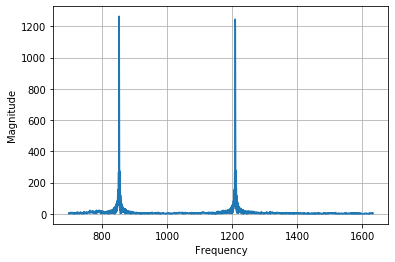

1


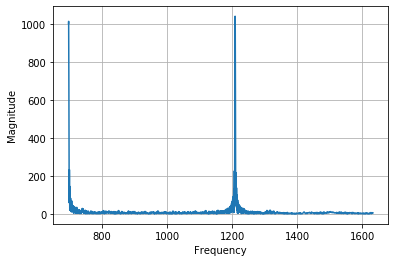

8


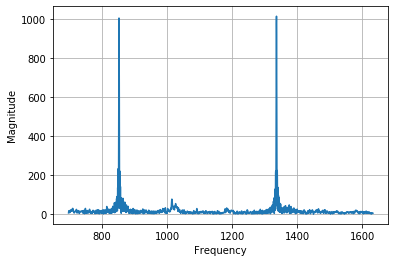

2


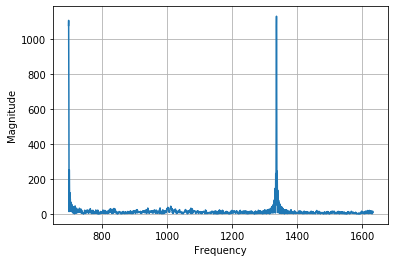

2


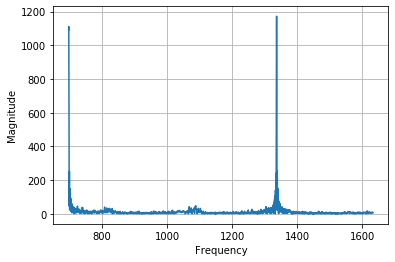

4


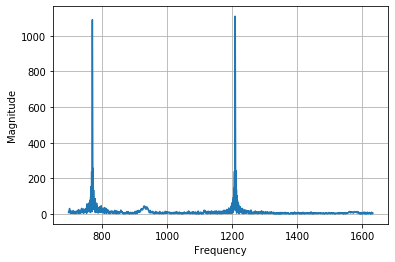

5


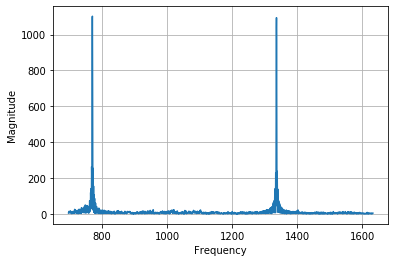

0


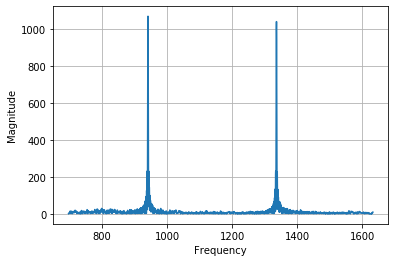

3


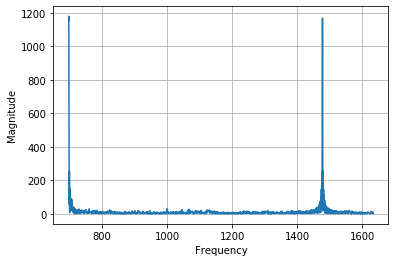

In [11]:
res = ''
for i, chunk in enumerate(chunks):
    chunk = chunk.high_pass_filter(697)
    
    silence_chunk = AudioSegment.silent(duration=500)

    audio_chunk = silence_chunk + chunk + silence_chunk

    normalized_chunk = match_target_amplitude(audio_chunk, -20.0)

    data = np.array(normalized_chunk.get_array_of_samples())
        
    dtmf, _ = fft_plot(data, Fs)
    
    res += dtmf

In [12]:
print(res)

718224503
